In [1]:
import pandas as pd
import numpy as np

In [2]:
result_path = '/home/jibeiroa/desercion_escolar_argentina/models/results_unsampled.csv'
results = pd.read_csv(result_path)

# Resultados en data no resampleada
Entrené logística con regularización l1 (Lasso), árbol de decisión y random forest.

In [3]:
results

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__class_weight,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0,1.665980,0.178828,0.385153,0.046884,"LogisticRegression(penalty='l1', solver='libli...",0.001,"{0: 0.01, 1: 3.5668814293448836}",NaN,NaN,{'classifier': LogisticRegression(penalty='l1'...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
1,1,1.404046,0.176899,0.411687,0.119180,"LogisticRegression(penalty='l1', solver='libli...",0.001,"{0: 0.0734723444190275, 1: 3.1705612705287853}",NaN,NaN,{'classifier': LogisticRegression(penalty='l1'...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
2,2,1.368336,0.185351,0.450326,0.125613,"LogisticRegression(penalty='l1', solver='libli...",0.001,"{0: 0.13694468883805502, 1: 2.774241111712687}",NaN,NaN,{'classifier': LogisticRegression(penalty='l1'...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
3,3,1.546045,0.126216,0.442642,0.145534,"LogisticRegression(penalty='l1', solver='libli...",0.001,"{0: 0.20041703325708254, 1: 2.377920952896589}",NaN,NaN,{'classifier': LogisticRegression(penalty='l1'...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
4,4,1.416472,0.134118,0.383589,0.076307,"LogisticRegression(penalty='l1', solver='libli...",0.001,"{0: 0.26388937767611004, 1: 1.9816007940804907}",NaN,NaN,{'classifier': LogisticRegression(penalty='l1'...,0.853659,0.767568,0.889189,0.783198,0.859079,0.830538,0.046894,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,481,2.551847,0.774092,0.569892,0.121690,RandomForestClassifier(),NaN,"{0: 0.5177787553522201, 1: 0.3963201588160983}",NaN,28.0,"{'classifier': RandomForestClassifier(), 'clas...",0.089431,0.067568,0.078378,0.081301,0.094851,0.082306,0.009400,322
482,482,3.006906,0.582197,0.436364,0.085009,RandomForestClassifier(),NaN,"{0: 0.5177787553522201, 1: 0.3963201588160983}",NaN,30.0,"{'classifier': RandomForestClassifier(), 'clas...",0.108401,0.081081,0.064865,0.084011,0.073171,0.082306,0.014649,322
483,483,2.575882,0.481422,0.544489,0.134928,RandomForestClassifier(),NaN,"{0: 0.5177787553522201, 1: 0.3963201588160983}",NaN,32.0,"{'classifier': RandomForestClassifier(), 'clas...",0.078591,0.059459,0.056757,0.065041,0.094851,0.070940,0.014128,352
484,484,1.839670,0.280645,0.369842,0.047501,RandomForestClassifier(),NaN,"{0: 0.5177787553522201, 1: 0.3963201588160983}",NaN,34.0,"{'classifier': RandomForestClassifier(), 'clas...",0.086721,0.086486,0.056757,0.075881,0.075881,0.076345,0.010905,333


In [18]:
# mejores scores --> casi todas las logísticas tienen score=1
best = results[results.mean_test_score == results.mean_test_score.max()]

In [19]:
# parámetros de las logísticas
best[['param_classifier__C', 'param_classifier__class_weight']]

,param_classifier__C,param_classifier__class_weight
0,0.001000,"{0: 0.01, 1: 3.5668814293448836}"
1,0.001000,"{0: 0.0734723444190275, 1: 3.1705612705287853}"
2,0.001000,"{0: 0.13694468883805502, 1: 2.774241111712687}"
3,0.001000,"{0: 0.20041703325708254, 1: 2.377920952896589}"
9,0.001101,"{0: 0.01, 1: 3.5668814293448836}"
...,...,...
199,0.008254,"{0: 0.0734723444190275, 1: 3.1705612705287853}"
207,0.009085,"{0: 0.01, 1: 3.5668814293448836}"
208,0.009085,"{0: 0.0734723444190275, 1: 3.1705612705287853}"
216,0.010000,"{0: 0.01, 1: 3.5668814293448836}"


# Entrenamiento de mejores modelos

In [13]:
import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt

from desercion_escolar_argentina.utils import file_handler as fh
from desercion_escolar_argentina.artifacts import imputer as im
from desercion_escolar_argentina.artifacts import scaler as sc
from desercion_escolar_argentina.artifacts import encoder as enc

In [20]:
# datos de train y test
id_cols = [
    'CODUSU', 'NRO_HOGAR', 'COMPONENTE', 'ANO4', 'TRIMESTRE', 'PONDERA'
]

repo_path = fh.get_repo_path()
train_path = os.path.join(repo_path, 'data/preprocessed/', 'preprocessed_train.csv')
test_path = os.path.join(repo_path, 'data/preprocessed/', 'preprocessed_test.csv')
train_data = pd.read_csv(train_path)
train_data = train_data.loc[:, ~train_data.columns.isin(id_cols)]
test_data = pd.read_csv(test_path)
test_data = test_data.loc[:, ~test_data.columns.isin(id_cols)]


X_train = train_data.loc[:, train_data.columns != 'DESERTO']
y_train = train_data.loc[:, train_data.columns == 'DESERTO'].values.ravel()

X_test = test_data.loc[:, test_data.columns != 'DESERTO']
y_test = test_data.loc[:, test_data.columns == 'DESERTO'].values.ravel()

Mejor modelo: 
Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('knnimputer-1',
                                                  KNNImputer(missing_values=9.0,
                                                             n_neighbors=1),
                                                  ['CH07', 'CH08', 'CH11', 'V1',
                                                   'V2', 'V3', 'V5', 'V6', 'V7',
                                                   'V8', 'V11', 'V12', 'V13',
                                                   'V14', 'PP07I_jefx']),
                                                 ('knnimputer-2',
                                                  KNNImputer(missing_values=99.0,
                                                             n_neighbors=1),
                                                  ['IV2', 'II1']),
                                                 ('knnimputer-3',
 

/home/jibeiroa/.cache/pypoetry/virtualenvs/desercion-escolar-argentina-cRgMUP6I-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Text(0.5, 1.0, 'Matriz de confusión del mejor modelo en recall')

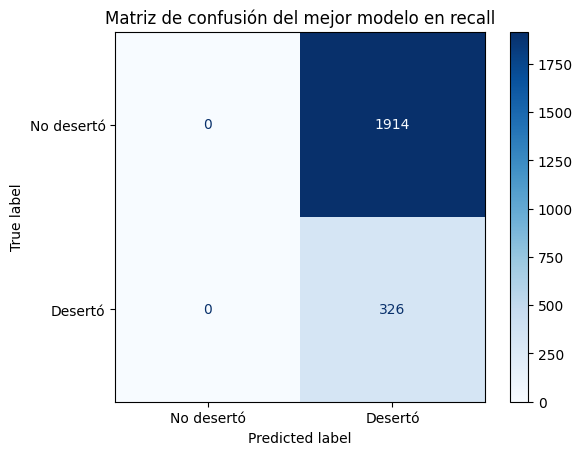

In [21]:
# pipeline con imputer, scaler y encoder
pipeline = Pipeline([
    ('imputer', im.make_imputer()),
    ('scaler', sc.make_scaler()),
    ('encoder', enc.make_encoder()),
    ('classifier', LogisticRegression(penalty='l1', 
                                      solver='liblinear',
                                      C=0.001,
                                      class_weight={0: 0.01, 1: 3.5668814293448836}))
]).set_output(transform='pandas')

model = pipeline.fit(X_train, y_train)
print(f"Mejor modelo: \n{model}\n----")

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['No desertó', 'Desertó']

Display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

Display.plot(cmap=plt.cm.Blues)
plt.title(f'Matriz de confusión del mejor modelo en recall')

# RECALL = 1??? Qué magia negra es esta?

In [22]:
coefs = pd.DataFrame(model.named_steps['classifier'].coef_, columns=model.named_steps['encoder'].get_feature_names_out()).T
coefs.rename({0: 'value'}, axis=1, inplace=True)

/tmp/ipykernel_278134/4266057377.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  coefs.sort_values(by='value', ascending=False)[coefs.value != 0.0].plot(kind='bar')


<Axes: >

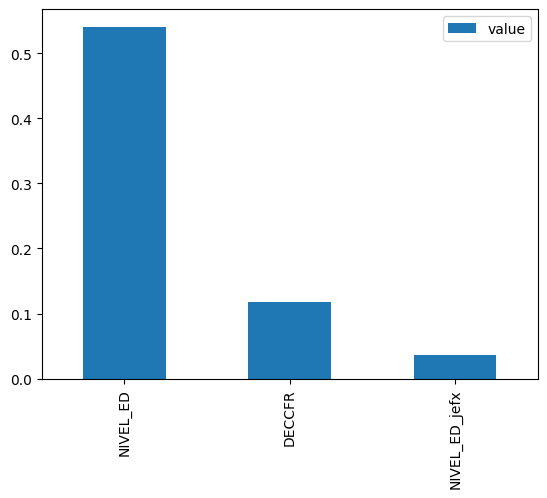

In [23]:
coefs.sort_values(by='value', ascending=False)[coefs.value != 0.0].plot(kind='bar')

Con la regularización de la logística, sobreviven sólo tres variables que evidentemente predicen muy bien en test. Veamos qué sucede en train.

Text(0.5, 1.0, 'Matriz de confusión del mejor modelo en datos de train recall')

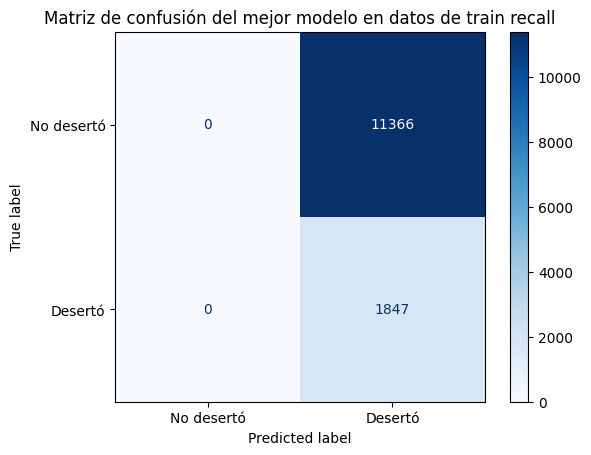

In [25]:
y_pred_train = model.predict(X_train)
conf_matrix = confusion_matrix(y_train, y_pred_train)
class_names = ['No desertó', 'Desertó']

Display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

Display.plot(cmap=plt.cm.Blues)
plt.title(f'Matriz de confusión del mejor modelo en datos de train recall')